# Scene Gray2RGB

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

## Prepare the dataset

In [4]:
# Un comment when downloading the dataset
# !wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
# !unzip ADEChallengeData2016.zip

In [12]:
data_folder = os.path.join('ADEChallengeData2016', 'images')
train_images = [os.path.join(data_folder, 'training', x) for x in os.listdir(os.path.join(data_folder, 'training')) if x.endswith('.jpg')]
test_images = [os.path.join(data_folder, 'validation', x) for x in os.listdir(os.path.join(data_folder, 'validation')) if x.endswith('.jpg')]
print('Train images: {}'.format(len(train_images)))
print('Test images: {}'.format(len(test_images)))

Train images: 20210
Test images: 2000


In [13]:
train_images[:5]

['ADEChallengeData2016/images/training/ADE_train_00019284.jpg',
 'ADEChallengeData2016/images/training/ADE_train_00010446.jpg',
 'ADEChallengeData2016/images/training/ADE_train_00005260.jpg',
 'ADEChallengeData2016/images/training/ADE_train_00003177.jpg',
 'ADEChallengeData2016/images/training/ADE_train_00008356.jpg']

In [14]:
test_images[:5]

['ADEChallengeData2016/images/validation/ADE_val_00001257.jpg',
 'ADEChallengeData2016/images/validation/ADE_val_00001767.jpg',
 'ADEChallengeData2016/images/validation/ADE_val_00000956.jpg',
 'ADEChallengeData2016/images/validation/ADE_val_00001631.jpg',
 'ADEChallengeData2016/images/validation/ADE_val_00001065.jpg']

In [15]:
def map_image(image_path):
  rgb = tf.io.read_file(image_path)
  rgb = tf.image.decode_jpeg(rgb, channels=3)
  rgb = tf.image.resize(rgb, (224, 224))
  gray = tf.image.rgb_to_grayscale(rgb)
  rgb = tf.cast(rgb, dtype=tf.float32)
  gray = tf.cast(gray, dtype=tf.float32)
  rgb = rgb / 255.0
  gray = gray / 255.0
  return gray, rgb

In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [17]:
def encoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
  return max_pool_2

In [18]:
def bottle_neck(inputs):
  bottle_neck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(bottle_neck)
  return bottle_neck, encoder_visualization

In [19]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(up_sample_2)
  return conv_3

In [20]:
def convolutional_autoencoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(224, 224, 1))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  model = tf.keras.Model(inputs=inputs, outputs=decoder_output)  
  return model, encoder_model

In [21]:
convolutional_model, convolutional_encoder_model = convolutional_autoencoder()
convolutional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       2950

In [22]:
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='mean_squared_error')

## Train the model

In [23]:
train_steps = len(train_images) // BATCH_SIZE
valid_steps = len(test_images) // BATCH_SIZE

history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                  validation_data=test_dataset, validation_steps=valid_steps, 
                                  epochs=10)

Epoch 1/10
631/631 [==============================] - 380s 540ms/step - loss: 0.0173 - accuracy: 0.4879 - val_loss: 0.0095 - val_accuracy: 0.5090
Epoch 2/10
631/631 [==============================] - 342s 537ms/step - loss: 0.0095 - accuracy: 0.5052 - val_loss: 0.0087 - val_accuracy: 0.4684
Epoch 3/10
631/631 [==============================] - 341s 541ms/step - loss: 0.0086 - accuracy: 0.5110 - val_loss: 0.0082 - val_accuracy: 0.5317
Epoch 4/10
631/631 [==============================] - 340s 540ms/step - loss: 0.0082 - accuracy: 0.5158 - val_loss: 0.0077 - val_accuracy: 0.5298
Epoch 5/10
631/631 [==============================] - 341s 540ms/step - loss: 0.0078 - accuracy: 0.5224 - val_loss: 0.0076 - val_accuracy: 0.5388
Epoch 6/10
631/631 [==============================] - 343s 543ms/step - loss: 0.0076 - accuracy: 0.5302 - val_loss: 0.0074 - val_accuracy: 0.5384
Epoch 7/10
631/631 [==============================] - 343s 544ms/step - loss: 0.0075 - accuracy: 0.5338 - val_loss: 0.0075 -

## Display sample

In [24]:
from google.colab import files

In [149]:
from_dataset = True

if from_dataset:
  test_data = next(iter(test_dataset))
  idx = 13
  gray_img = test_data[0][idx]
  color_img = test_data[1][idx]
else:
  uploaded = files.upload()
  for fn in uploaded.keys():
    gray_img, color_img = map_image(fn)

In [150]:
predicted = convolutional_model.predict(gray_img[tf.newaxis, ...])

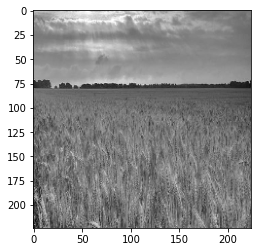

In [151]:
plt.imshow(np.squeeze(gray_img), cmap='gray')

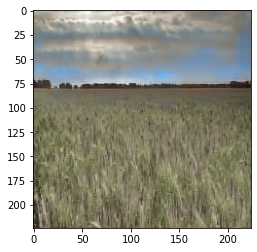

In [152]:
plt.imshow(np.squeeze(predicted))

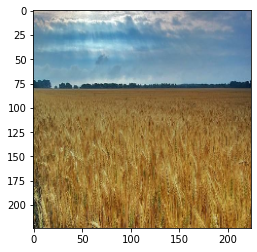

In [153]:
plt.imshow(np.squeeze(color_img))